<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Codigo_completo_(Modelos_predictivos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base de datos **(La Paz)**

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo, sep=';')  # Quien use este codigo asegúrate de usar el separador correcto

num_observaciones, num_variables = df.shape
print(f"Número de observaciones (filas): {num_observaciones}")
print(f"Número de variables (columnas): {num_variables}")

print("\n Lista de variables:")
print(df.columns.tolist())

Saving base_datos_solar_lapaz_2025 (1).csv to base_datos_solar_lapaz_2025 (1).csv
Número de observaciones (filas): 2880
Número de variables (columnas): 6

 Lista de variables:
['time', 'shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'energia_solar_kWh']



# Modelo XGBoost usando series de tiempo

**Objetivo del Proyecto**

Desarrollar un modelo de predicción para estimar la generación de energía solar en La Paz (Cesar), a partir de variables meteorológicas y temporales, mediante técnicas de aprendizaje automático con enfoque en series de tiempo.

### Cargar los datos, convertir la fecha y ordenarlos

Importamos los datos desde un archivo `.csv`, donde cada fila representaba una hora del día y contenía las condiciones meteorológicas en ese momento y cuánta energía solar se había generado.

In [ ]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df.head()

,time,shortwave_radiation,temperature_2m,wind_speed_10m,relative_humidity_2m,energia_solar_kWh
0,2025-02-01 00:00:00,0.0,25.5,23.1,68,0.0
1,2025-02-01 01:00:00,0.0,25.0,21.8,69,0.0
2,2025-02-01 02:00:00,0.0,24.6,20.3,70,0.0
3,2025-02-01 03:00:00,0.0,24.3,19.7,72,0.0
4,2025-02-01 04:00:00,0.0,23.9,18.9,74,0.0


### Crear variables temporales y de retraso (lags)


| **Variable**           | **Significado**                                                                       |
| ---------------------- | ------------------------------------------------------------------------------------- |
| `temperature_2m`       | Temperatura del aire medida a 2 metros del suelo (°C). Afecta eficiencia de paneles.  |
| `wind_speed_10m`       | Velocidad del viento a 10 metros (m/s). Puede influir en refrigeración de paneles.    |
| `relative_humidity_2m` | Porcentaje de humedad del aire a 2 metros. Alta humedad suele implicar nubosidad.     |
| `hora`                 | Hora del día (0 a 23). Refleja el ciclo diario de generación solar.                   |
| `dia`                  | Día del mes. Útil para captar variaciones cortas.                                     |
| `mes`                  | Mes del año. Captura la estacionalidad anual.                                         |
| `dia_del_año`          | Día juliano (1–365). Mejora la captación de patrones anuales más finos.               |
| `dia_semana`           | Día de la semana (0=lunes, 6=domingo). Puede ser útil si hay diferencias semanales.   |
| `energia_lag_1`        | Energía solar generada **una hora antes**. Captura inercia inmediata en el sistema.   |
| `energia_lag_24`       | Energía solar generada **24 horas antes**. Ayuda a captar patrones diarios.           |
| `energia_roll_3`       | Promedio de energía en las **últimas 3 horas**. Suaviza y refleja tendencia reciente. |

In [ ]:
import numpy as np

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(window=3).mean()

df = df.dropna()

df[['time', 'energia_solar_kWh', 'energia_lag_1', 'energia_lag_24', 'energia_roll_3']].head()


,time,energia_solar_kWh,energia_lag_1,energia_lag_24,energia_roll_3
24,2025-02-02 00:00:00,0.0,0.0,0.0,0.0
25,2025-02-02 01:00:00,0.0,0.0,0.0,0.0
26,2025-02-02 02:00:00,0.0,0.0,0.0,0.0
27,2025-02-02 03:00:00,0.0,0.0,0.0,0.0
28,2025-02-02 04:00:00,0.0,0.0,0.0,0.0


### Definir las variables predictoras `(X)` y la variable objetivo `(y)`, excluyendo shortwave_radiation

In [ ]:
X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])

y = df['energia_solar_kWh']

print(" Variables predictoras (X):", list(X.columns))
print("\n Tamaño de X:", X.shape)
print(" Tamaño de y:", y.shape)

 Variables predictoras (X): ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'hora', 'dia', 'mes', 'dia_del_año', 'dia_semana', 'energia_lag_1', 'energia_lag_24', 'energia_roll_3']

 Tamaño de X: (2856, 11)
 Tamaño de y: (2856,)


### Separar los datos en entrenamiento y prueba (respetando el tiempo)

Como estamos trabajando con series de tiempo, no debemos mezclar datos del pasado y futuro de forma aleatoria. Por eso:

- Usaremos 80% de los datos más antiguos para entrenamiento

- Y el 20% más reciente para prueba

Esto imita cómo funcionaría el modelo en la vida real: entrena con el pasado y predice el futuro.

Usamos el 80% de los datos antiguos para entrenar el modelo (como si estuviéramos en el pasado), y el 20% más reciente para probarlo (como si predijéramos el futuro). Esto es muy importante en modelos con series de tiempo.

In [ ]:
n = len(df)
n_train = int(n * 0.8)

X_train = X.iloc[:n_train]
X_test = X.iloc[n_train:]
y_train = y.iloc[:n_train]
y_test = y.iloc[n_train:]

print(f" Tamaño entrenamiento: {X_train.shape[0]} registros")
print(f" Tamaño prueba: {X_test.shape[0]} registros")


 Tamaño entrenamiento: 2284 registros
 Tamaño prueba: 572 registros


### Búsqueda de los mejores hiperparámetros

Vamos a usar `GridSearchCV` con validación cruzada para encontrar la mejor combinación de hiperparámetros para el modelo XGBoost.

Hasta encontrar la que da el menor error de predicción.

| Parámetro          | Qué controla                    | Valores a probar   |
| ------------------ | ------------------------------- | ------------------ |
| `n_estimators`     | Nº de árboles                   | \[100, 200]        |
| `max_depth`        | Profundidad máxima del árbol    | \[3, 5, 7]         |
| `learning_rate`    | Tasa de aprendizaje (step size) | \[0.01, 0.05, 0.1] |
| `subsample`        | % de datos usados por árbol     | \[0.8, 1.0]        |
| `colsample_bytree` | % de variables usadas por árbol | \[0.8, 1.0]        |


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
print(" Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

 Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


### Entrenar el modelo XGBoost con los hiperparámetros óptimos

In [ ]:
from xgboost import XGBRegressor

modelo_final = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

modelo_final.fit(X_train, y_train)

print(" Modelo entrenado con éxito.")

 Modelo entrenado con éxito.


### Evaluar el modelo

-  RMSE: error cuadrático medio raíz (error promedio en kWh).
- R² (R al cuadrado): qué tan bien explica el modelo la variabilidad.
- Gráfico de valores reales vs predichos: para ver si el modelo sigue bien la tendencia.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = modelo_final.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" RMSE: {rmse:.4f}")
print(f" R²: {r2:.4f}")

 RMSE: 0.0127
 R²: 0.9757


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
print(f" MAE (XGBoost): {mae:.4f}")

import numpy as np

y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

mask = y_test_np != 0
y_test_filtered = y_test_np[mask]
y_pred_filtered = y_pred_np[mask]

mape_filtered = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered)

 MAE (XGBoost): 0.0065


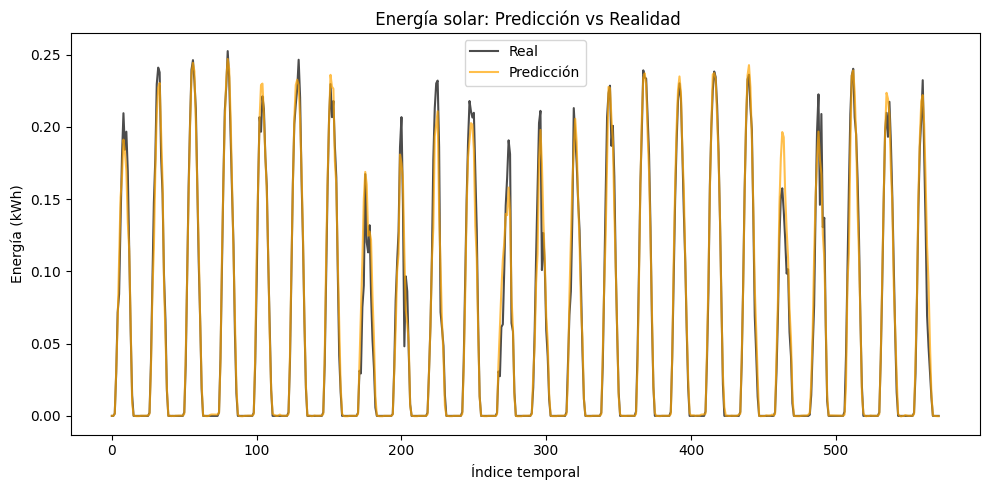

In [ ]:
# Gráfico de comparación
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Real", color="black", alpha=0.7)
plt.plot(y_pred, label="Predicción", color="orange", alpha=0.7)
plt.title(" Energía solar: Predicción vs Realidad")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluar la importancia de las variables del modelo

Vamos a visualizar qué variables fueron más relevantes para el modelo XGBoost entrenado sin radiación solar, usando el atributo .feature_importances_.

/tmp/ipython-input-13-1132959553.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia, x='Importancia (%)', y='Variable', palette='viridis')


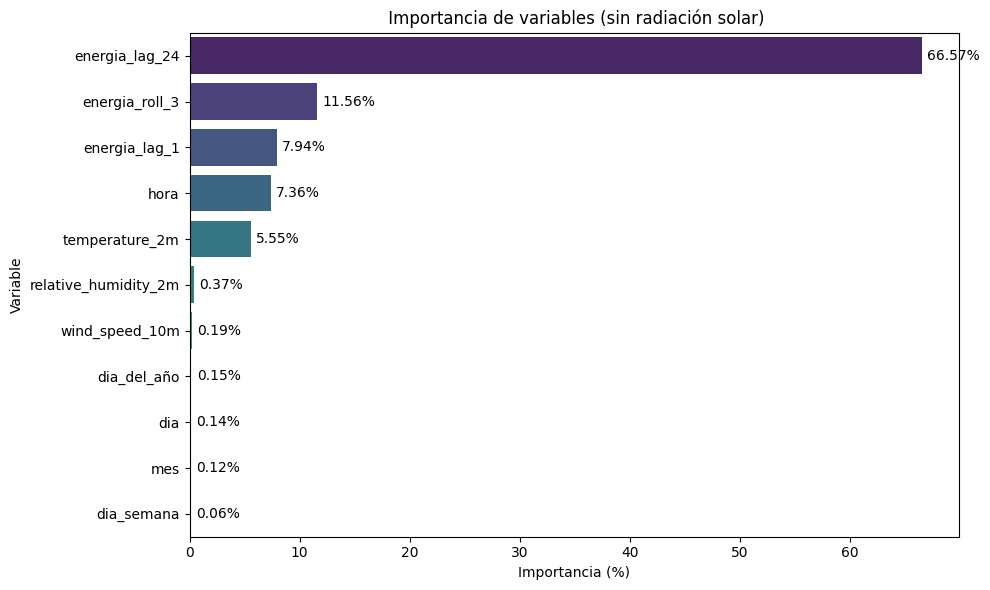

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importancias = modelo_final.feature_importances_
nombres = X_train.columns
porcentajes = 100 * (importancias / importancias.sum())

df_importancia = pd.DataFrame({
    'Variable': nombres,
    'Importancia (%)': porcentajes
}).sort_values(by='Importancia (%)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancia, x='Importancia (%)', y='Variable', palette='viridis')

for i, (valor, nombre) in enumerate(zip(df_importancia['Importancia (%)'], df_importancia['Variable'])):
    plt.text(valor + 0.5, i, f"{valor:.2f}%", va='center')

plt.title(" Importancia de variables (sin radiación solar)")
plt.xlabel("Importancia (%)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

| Variable                                 | Importancia (%) | ¿Qué significa esto?                                                                                                              |
| ---------------------------------------- | --------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **`energia_lag_24`**                     | **66.57%**      | La energía generada **24 horas antes** es el predictor más poderoso. El modelo aprendió que hay **patrones diarios repetitivos**. |
| `energia_roll_3`                         | 11.56%          | El **promedio de energía de las últimas 3 horas** aporta tendencia reciente. Muy útil para estabilidad.                           |
| `energia_lag_1`                          | 7.94%           | La energía de **la hora anterior** también ayuda a afinar la predicción inmediata.                                                |
| `hora`                                   | 7.36%           | Captura la **estacionalidad diaria** (el sol aparece a ciertas horas).                                                            |
| `temperature_2m`                         | 5.55%           | La temperatura afecta indirectamente la eficiencia del sistema.                                                                   |
| Otras (`humedad`, `viento`, `mes`, etc.) | <1%             | Contribuyen muy poco en comparación, pero aportan contexto climático y temporal.                                                  |


Esto demuestra que el modelo aprendió patrones diarios, horarios y térmicos de generación de energía.

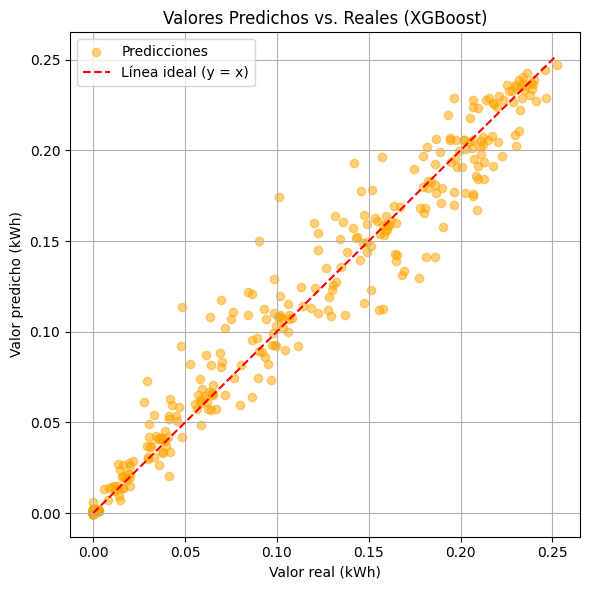

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Asegurar que los datos estén en formato 1D
y_test_array = np.array(y_test).ravel()
y_pred_array = np.array(y_pred).ravel()

# Gráfico de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_test_array, y_pred_array, color='orange', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_test_array)], [0, max(y_test_array)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Aproximaciones

## Modelo GRU

 **¿Qué necesitas saber sobre GRU?**
- Es una versión más ligera de LSTM, pero igual de buena para series de tiempo.
- Aprende patrones de largo y corto plazo sin necesidad de crear lags manualmente (aunque podemos incluirlos también).
- Funciona mejor si organizamos los datos como secuencias: por ejemplo, usar las últimas 24 horas para predecir la siguiente.

### generar secuencias para GRU

Vamos a usar una ventana de 24 horas (1 día) como entrada para predecir la energía de la siguiente hora.

In [ ]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

df = df.dropna()

X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])
        y.append(datos[i, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

print(" Formato de X (samples, pasos, variables):", X_seq.shape)
print(" Formato de y:", y_seq.shape)

 Formato de X (samples, pasos, variables): (2832, 24, 6)
 Formato de y: (2832,)


### Separar datos en entrenamiento y prueba (para GRU)

- 80% para entrenamiento
- 20% más reciente para prueba

In [ ]:
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test:", y_test.shape)

 X_train: (2265, 24, 6)
 X_test: (567, 24, 6)
 y_train: (2265,)
 y_test: (567,)


- 2265 muestras para entrenamiento
- 567 muestras para prueba

Cada muestra es una secuencia de 24 horas con 6 variables

###  Construir y entrenar el modelo GRU

Usaremos `Keras` con `TensorFlow` como backend. Vamos a:

- Crear una red GRU simple con:
  - 1 capa GRU
  - 1 capa densa de salida
- Compilar con función de pérdida MSE
- Entrenar por 30 épocas

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

modelo_gru = Sequential([
    GRU(64, input_shape=(24, 6), return_sequences=False),
    Dense(1)
])

modelo_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

historial = modelo_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0824 - mae: 0.2135 - val_loss: 0.0107 - val_mae: 0.0845
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0087 - mae: 0.0759 - val_loss: 0.0054 - val_mae: 0.0562
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0040 - mae: 0.0502 - val_loss: 0.0046 - val_mae: 0.0495
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - mae: 0.0439 - val_loss: 0.0043 - val_mae: 0.0466
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0030 - mae: 0.0429 - val_loss: 0.0040 - val_mae: 0.0432
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0024 - mae: 0.0382 - val_loss: 0.0039 - val_mae: 0.0423
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024 - mae: 0.0372 - val_loss: 0.0041 - val_mae: 0.0438
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0026 - mae: 0.0390 - val_loss: 0.0040 - val_mae: 0.0474
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.002

El modelo GRU se entrenó correctamente y fue aprendiendo con cada época. El valor de pérdida (`val_loss`) se fue estabilizando en torno a 0.0031, lo cual ya nos indica un buen ajuste.

### Evaluar el modelo GRU con RMSE y R² en el conjunto de prueba

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_pred_scaled = modelo_gru.predict(X_test)

y_test_full = np.zeros((len(y_test), 6))
y_test_full[:, -1] = y_test
y_pred_full = np.zeros((len(y_pred_scaled), 6))
y_pred_full[:, -1] = y_pred_scaled[:, 0]

y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]

rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_gru = r2_score(y_test_inv, y_pred_inv)

print(f" RMSE (GRU): {rmse_gru:.4f}")
print(f" R² (GRU): {r2_gru:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
 RMSE (GRU): 0.0143
 R² (GRU): 0.9692


In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae_gru = mean_absolute_error(y_test_inv, y_pred_inv)
print(f" MAE (GRU): {mae_gru:.4f}")

 MAE (GRU): 0.0083


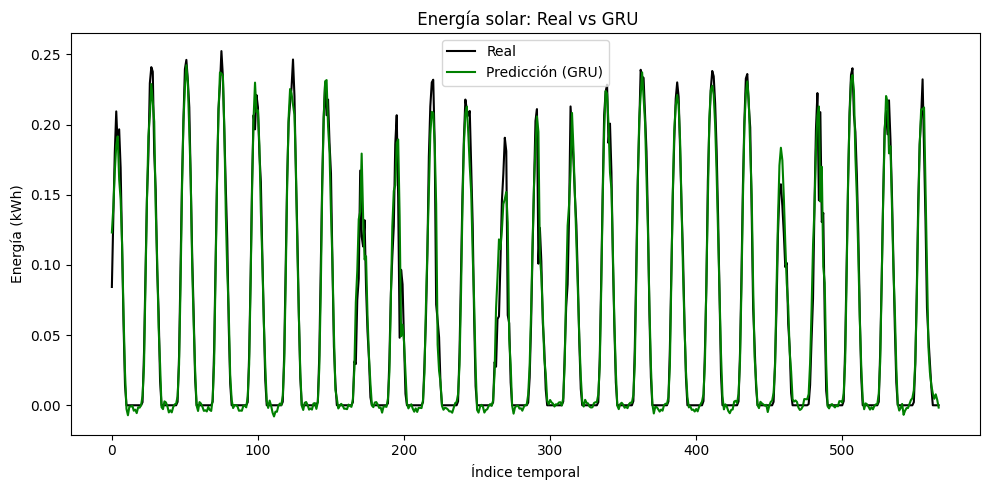

In [ ]:
# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Real', color='black')
plt.plot(y_pred_inv, label='Predicción (GRU)', color='green')
plt.title(" Energía solar: Real vs GRU")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

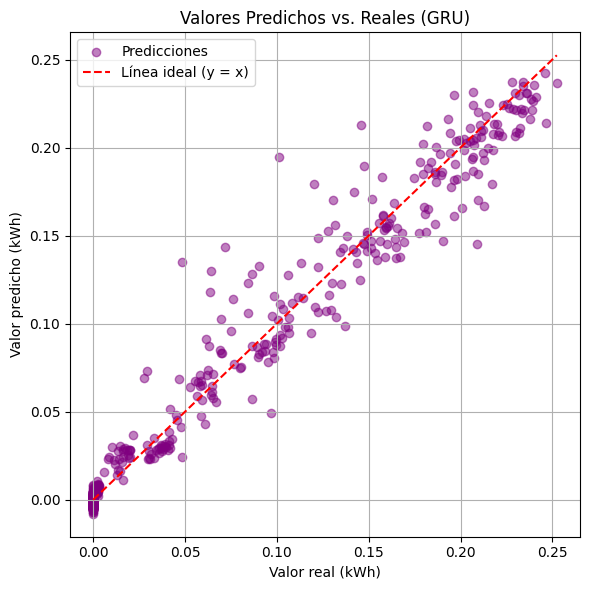

In [ ]:
import matplotlib.pyplot as plt

y_true_flat_gru = y_test_inv.ravel()
y_pred_flat_gru = y_pred_inv.ravel()

# Gráfica de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat_gru, y_pred_flat_gru, color='purple', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_flat_gru)], [0, max(y_true_flat_gru)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GRU)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Modelo MLP (Perceptrón Multicapa)

Un MLP:

- Aprende relaciones no lineales
- Se entrena más rápido que GRU o LSTM
- Se usa en muchos papers como baseline (modelo base)
- Es fácil de interpretar y comparar



### generar secuencias para GRU

Vamos a usar una ventana de 24 horas (1 día) como entrada para predecir la energía de la siguiente hora.

In [ ]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

df = df.dropna()

X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])
        y.append(datos[i, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

print(" Formato de X (samples, pasos, variables):", X_seq.shape)
print(" Formato de y:", y_seq.shape)

 Formato de X (samples, pasos, variables): (2832, 24, 6)
 Formato de y: (2832,)


### Separar datos en entrenamiento y prueba (para GRU)

- 80% para entrenamiento
- 20% más reciente para prueba

In [ ]:
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test:", y_test.shape)

 X_train: (2265, 24, 6)
 X_test: (567, 24, 6)
 y_train: (2265,)
 y_test: (567,)


### Aplanar las secuencias

In [ ]:
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

print(" Formato de X_train para MLP:", X_train_mlp.shape)
print(" Formato de X_test para MLP:", X_test_mlp.shape)

 Formato de X_train para MLP: (2265, 144)
 Formato de X_test para MLP: (567, 144)


### Construir y entrenar el modelo MLP

Vamos a usar una red neuronal simple:

- 2 capas ocultas con 128 y 64 neuronas
- Activación relu
- Capa de salida con 1 neurona (predicción de energía solar)
- Función de pérdida `mse`

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

modelo_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(144,)),
    Dense(64, activation='relu'),
    Dense(1)
])

modelo_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

historial_mlp = modelo_mlp.fit(
    X_train_mlp, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_mlp, y_test),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0231 - mae: 0.1041 - val_loss: 0.0075 - val_mae: 0.0621
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0396 - val_loss: 0.0070 - val_mae: 0.0593
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0062 - val_mae: 0.0555
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0415 - val_loss: 0.0055 - val_mae: 0.0517
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 0.0296 - val_loss: 0.0054 - val_mae: 0.0516
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0290 - val_loss: 0.0069 - val_mae: 0.0604
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mae: 0.0280 - val_loss: 0.0053 - val_mae: 0.0499
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0047 - val_mae: 0.0477
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 

El modelo MLP se entrenó bien y la función de pérdida (val_loss) terminó en 0.0034, lo que ya sugiere un buen ajuste.

### Evaluar el MLP (RMSE, R²)

In [ ]:
y_pred_mlp_scaled = modelo_mlp.predict(X_test_mlp)

y_test_full_mlp = np.zeros((len(y_test), 6))
y_test_full_mlp[:, -1] = y_test

y_pred_full_mlp = np.zeros((len(y_pred_mlp_scaled), 6))
y_pred_full_mlp[:, -1] = y_pred_mlp_scaled[:, 0]

y_test_inv_mlp = scaler.inverse_transform(y_test_full_mlp)[:, -1]
y_pred_inv_mlp = scaler.inverse_transform(y_pred_full_mlp)[:, -1]

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

rmse_mlp = np.sqrt(mean_squared_error(y_test_inv_mlp, y_pred_inv_mlp))
r2_mlp = r2_score(y_test_inv_mlp, y_pred_inv_mlp)

print(f" RMSE (MLP): {rmse_mlp:.4f}")
print(f" R² (MLP): {r2_mlp:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 RMSE (MLP): 0.0160
 R² (MLP): 0.9615


| Métrica | Valor  | Comentario                                  |
| ------- | ------ | ------------------------------------------- |
|  RMSE  | 0.0157 | Error bajo, pero mayor que GRU/XGBoost      |
|  R²    | 0.9630 | Explica el **96.3%** de la energía generada |


- El MLP funciona bien, pero no tan bien como:
  - GRU (R² = 96.3%)
  - XGBoost con series (R² = 97.57%)
- Aún así, es un modelo rápido, simple y estable, útil como base.

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae_mlp = mean_absolute_error(y_test_inv_mlp, y_pred_inv_mlp)
print(f" MAE (MLP): {mae_mlp:.4f}")

 MAE (MLP): 0.0096


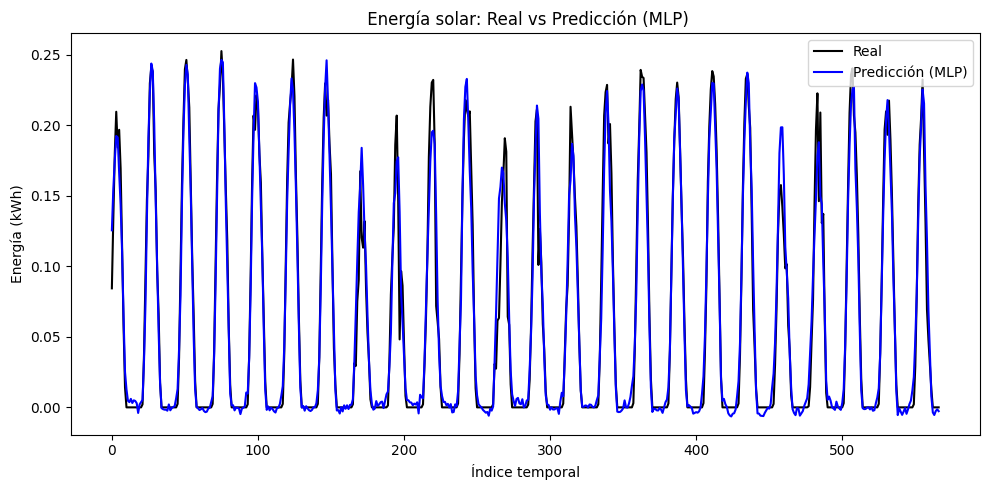

In [ ]:
# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv_mlp, label='Real', color='black')
plt.plot(y_pred_inv_mlp, label='Predicción (MLP)', color='blue')
plt.title(" Energía solar: Real vs Predicción (MLP)")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

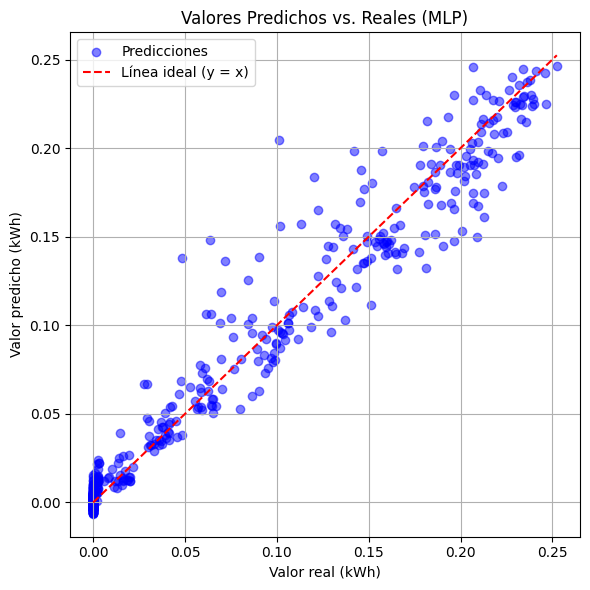

In [ ]:
import matplotlib.pyplot as plt

y_true_flat_mlp = y_test_inv_mlp.ravel()
y_pred_flat_mlp = y_pred_inv_mlp.ravel()

# Gráfica de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat_mlp, y_pred_flat_mlp, color='blue', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_flat_mlp)], [0, max(y_true_flat_mlp)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (MLP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Modelo ARMA

- AR (AutoRegresivo): se basa en los valores anteriores (lags) de la variable.
- MA (Media Móvil): se basa en el error de predicciones anteriores.
- ARMA mezcla ambos.

Pero importante: ARMA solo usa la variable objetivo (no usa otras variables).

### Preparar la serie de tiempo

Vamos a quedarnos solo con la columna `energia_solar_kWh` y asegurarnos de que esté indexada por el tiempo.

In [ ]:
serie_energia = df.set_index('time')['energia_solar_kWh']

serie_energia.head()

,energia_solar_kWh
time,
2025-02-01T00:00,0.0
2025-02-01T01:00,0.0
2025-02-01T02:00,0.0
2025-02-01T03:00,0.0
2025-02-01T04:00,0.0


### Ajustar el modelo ARMA

Probaremos con un modelo básico de orden (p=2, q=2):

- p = 2: número de lags (valores anteriores)
- q = 2: número de errores pasados

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arma = ARIMA(serie_energia, order=(2, 0, 2))
resultado_arma = modelo_arma.fit()

print(resultado_arma.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      energia_solar_kWh   No. Observations:                 2880
Model:                 ARIMA(2, 0, 2)   Log Likelihood                7588.652
Date:                Sat, 26 Jul 2025   AIC                         -15165.303
Time:                        23:05:27   BIC                         -15129.510
Sample:                    02-01-2025   HQIC                        -15152.402
                         - 05-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0677      0.003     22.255      0.000       0.062       0.074
ar.L1          1.7431      0.013    131.512      0.000       1.717       1.769
ar.L2         -0.8569      0.013    -67.883      0.0

 El modelo ARMA(2,0,2) se ajustó correctamente.

| Resultado         | Interpretación                                                               |
| ----------------- | ---------------------------------------------------------------------------- |
| `const ≈ 0.0677`  | Valor promedio base de energía solar.                                        |
| `ar.L1, ar.L2`    | La energía pasada tiene un fuerte efecto (especialmente la de 1 hora antes). |
| `ma.L1, ma.L2`    | El modelo también ajusta errores pasados para corregirse.                    |
| `sigma2 ≈ 0.0003` | Varianza del error muy baja → modelo preciso.                                |
| `AIC = -15165`    | Es una métrica que puede usarse para comparar modelos ARMA entre sí.         |
| `Prob(JB) = 0.00` | Los residuos **no son normales** (algo común en datos solares).              |
                                                           |


- El modelo aprendió bien el patrón horario de la serie de energía.
- La energía de 1 y 2 horas antes explican buena parte del valor actual.
- Aunque es un modelo solo univariado, logra captar bien el comportamiento de la energía.

### predicciones con el modelo ARMA

- Predecir los últimos 20% de los datos (igual que hicimos en XGBoost).
- Comparar los valores reales vs predichos.
- Calcular RMSE y R² para poder comparar con los otros modelos.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

n_test = 572
inicio = len(serie_energia) - n_test

predicciones_arma = resultado_arma.predict(start=inicio, end=len(serie_energia)-1)

reales = serie_energia.iloc[inicio:]

rmse_arma = np.sqrt(mean_squared_error(reales, predicciones_arma))
r2_arma = r2_score(reales, predicciones_arma)

print(f" RMSE (ARMA): {rmse_arma:.4f}")
print(f" R² (ARMA): {r2_arma:.4f}")

 RMSE (ARMA): 0.0212
 R² (ARMA): 0.9323


1. El modelo ARMA logró un buen ajuste solo con los valores pasados de la energía.

2. Aunque es un modelo clásico, se comportó bastante bien:

  - Su RMSE es un poco mayor que el de XGBoost (0.021)

  - Su R² es menor (93.2% vs 97.6%), pero sigue siendo aceptable

3. No usamos ninguna variable meteorológica, solo la secuencia histórica.

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

reales_np = reales.to_numpy()
pred_np = predicciones_arma.to_numpy()

mae_arma = mean_absolute_error(reales_np, pred_np)

print(f" MAE (ARMA): {mae_arma:.4f}")

 MAE (ARMA): 0.0145


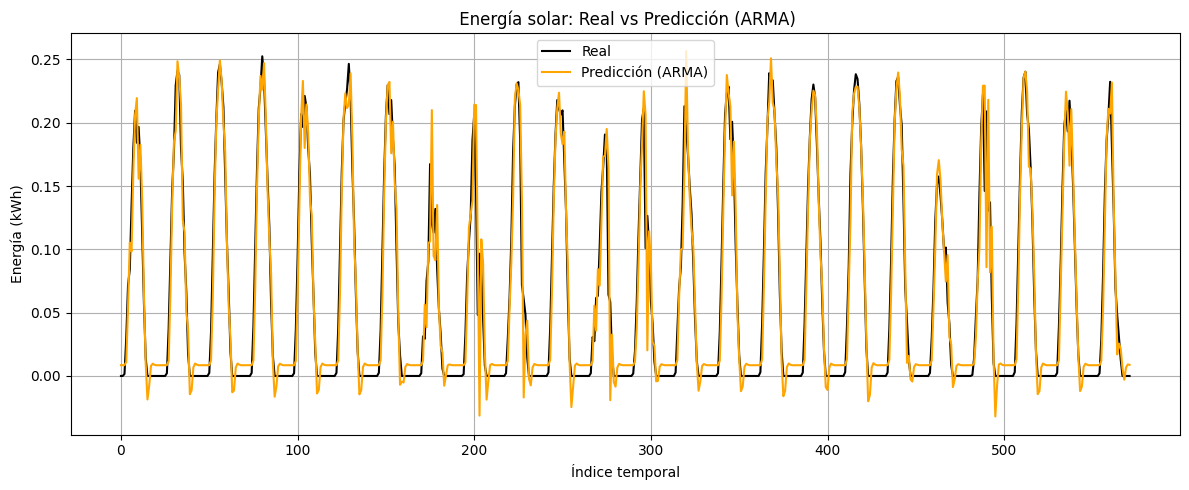

In [ ]:
# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(reales_np, label='Real', color='black')
plt.plot(pred_np, label='Predicción (ARMA)', color='orange')
plt.title(' Energía solar: Real vs Predicción (ARMA)')
plt.xlabel('Índice temporal')
plt.ylabel('Energía (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

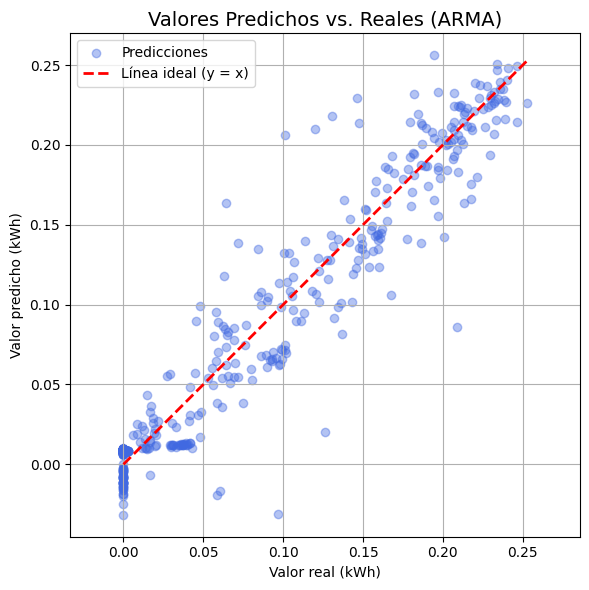

In [ ]:
import matplotlib.pyplot as plt

reales_np = reales.to_numpy()
pred_np = predicciones_arma.to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(reales_np, pred_np, alpha=0.4, color='royalblue', label='Predicciones')
plt.plot([reales_np.min(), reales_np.max()],
         [reales_np.min(), reales_np.max()],
         color='red', linestyle='--', linewidth=2, label='Línea ideal (y = x)')

plt.title('Valores Predichos vs. Reales (ARMA)', fontsize=14)
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


## Modelo GCN

**¿Qué es una GNN?**

Una Graph Neural Network es un modelo que aprende de relaciones entre nodos conectados. Se usa mucho en:
- Redes sociales
- Mapas de carreteras
- Sensores climáticos conectados
- Predicción espacial-temporal

Nuestro datos actuales NO son un grafo

Actualmente tienemos una única estación de datos (La Paz) con valores horarios, no nodos conectados entre sí. Por lo tanto:

**Alternativa viable que tenemos es:**

Usar una GNN simplificada para series temporales:

- Creamos un grafo de tipo "lineal", donde cada instante de tiempo es un nodo conectado al anterior.
- Esto simula una secuencia temporal como una cadena de nodos.



**Instalamos `torch_geometric`**

In [ ]:
#  Ejecutar solo en Colab (toma 1–2 minutos)
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 452.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.6 MB/s eta 0:00:00


### Preparar el grafo temporal

In [ ]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

df = df.dropna()

X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])
        y.append(datos[i, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

print(" Formato de X (samples, pasos, variables):", X_seq.shape)
print(" Formato de y:", y_seq.shape)

 Formato de X (samples, pasos, variables): (2832, 24, 6)
 Formato de y: (2832,)


In [ ]:
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test:", y_test.shape)

 X_train: (2265, 24, 6)
 X_test: (567, 24, 6)
 y_train: (2265,)
 y_test: (567,)


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np

X_gnn = X_seq.reshape(X_seq.shape[0], -1)
y_gnn = y_seq

x = torch.tensor(X_gnn, dtype=torch.float)
y = torch.tensor(y_gnn, dtype=torch.float).view(-1, 1)

edge_index = torch.tensor([
    [i, i+1] for i in range(x.size(0) - 1)
], dtype=torch.long).t().contiguous()

data = Data(x=x, y=y, edge_index=edge_index)

print(f" Nodos: {data.num_nodes}, Conexiones: {data.num_edges}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


 Nodos: 2832, Conexiones: 2831


Aunque hubo un warning de compatibilidad con las bibliotecas CUDA (torch-scatter y torch-sparse), el grafo fue creado correctamente:

- 2832 nodos (uno por cada hora)
- 2831 conexiones (una entre cada hora y la siguiente)

Esto es suficiente para continuar con un modelo GCN básico en CPU (funcionará igual aunque sea más lento).

### Construir el modelo GCN

Ahora creamos una red neuronal con 2 capas de tipo `GCNConv`:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

modelo_gcn = GCN(in_channels=144, hidden_channels=64, out_channels=1)

optimizer = torch.optim.Adam(modelo_gcn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


### Entrenar el modelo GCN

Vamos a entrenar el modelo con todos los nodos del grafo (no se divide en entrenamiento/test explícitamente, porque los nodos ya están ordenados en el tiempo).

Aun así, tomaremos los últimos 20% de los nodos para evaluación.

In [ ]:
for epoch in range(1, 201):
    modelo_gcn.train()
    optimizer.zero_grad()
    pred = modelo_gcn(data.x, data.edge_index)
    loss = loss_fn(pred, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"🧪 Epoch {epoch}, Loss: {loss.item():.6f}")

n_test = int(len(data.y) * 0.2)
y_true_gcn = data.y[-n_test:].detach().numpy()
y_pred_gcn = pred[-n_test:].detach().numpy()

from sklearn.metrics import mean_squared_error, r2_score
rmse_gcn = np.sqrt(mean_squared_error(y_true_gcn, y_pred_gcn))
r2_gcn = r2_score(y_true_gcn, y_pred_gcn)

🧪 Epoch 1, Loss: 0.003445
🧪 Epoch 20, Loss: 0.003353
🧪 Epoch 40, Loss: 0.003264
🧪 Epoch 60, Loss: 0.003181
🧪 Epoch 80, Loss: 0.003104
🧪 Epoch 100, Loss: 0.003032
🧪 Epoch 120, Loss: 0.002965
🧪 Epoch 140, Loss: 0.002902
🧪 Epoch 160, Loss: 0.002842
🧪 Epoch 180, Loss: 0.002786
🧪 Epoch 200, Loss: 0.002733


In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

print(f" RMSE (GCN): {rmse_gcn:.4f}")
print(f" R² (GCN): {r2_gcn:.4f}")
mae_gcn = mean_absolute_error(y_true_gcn, y_pred_gcn)
print(f" MAE (GCN): {mae_gcn:.4f}")

 RMSE (GCN): 0.0762
 R² (GCN): 0.9365
 MAE (GCN): 0.0458


- El GCN aprendió bien los patrones temporales, pero no tan fino como GRU o XGBoost.
- Como esperábamos, una GNN básica en una secuencia lineal no supera a modelos específicos de series como GRU o XGBoost con lags.
- Este resultado valida que las GNN pueden usarse, pero no son la mejor opción cuando no hay relaciones espaciales reales entre múltiples nodos (como estaciones climáticas conectadas).



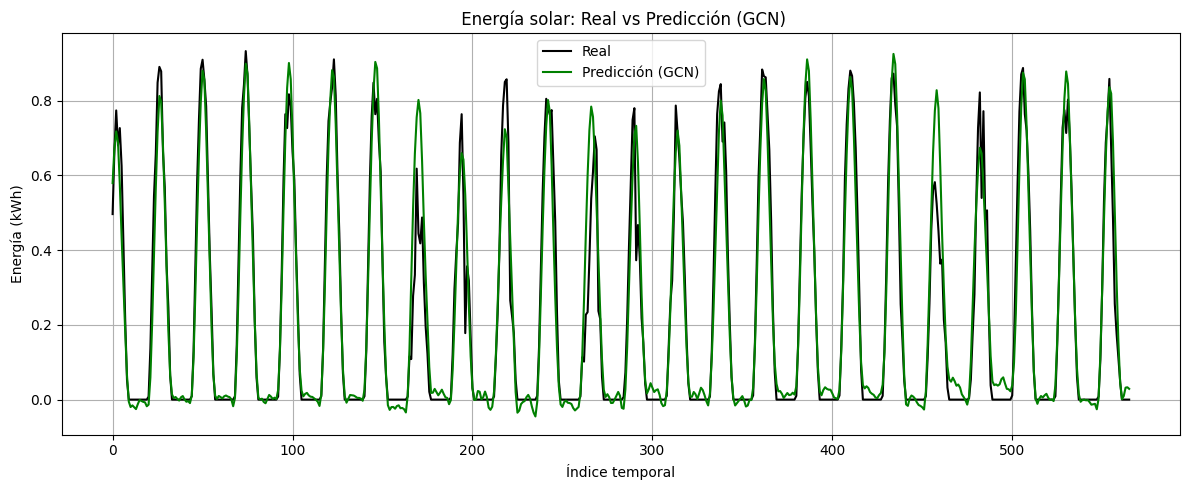

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_gcn, label='Real', color='black')
plt.plot(y_pred_gcn, label='Predicción (GCN)', color='green')
plt.title(" Energía solar: Real vs Predicción (GCN)")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

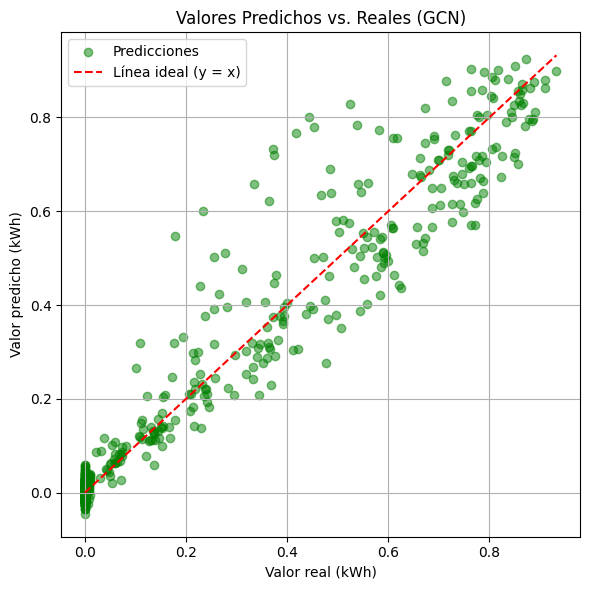

In [ ]:
# Asegurar vectores planos para la gráfica
y_true_gcn_flat = y_true_gcn.ravel()
y_pred_gcn_flat = y_pred_gcn.ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_true_gcn_flat, y_pred_gcn_flat, color='green', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_gcn_flat)], [0, max(y_true_gcn_flat)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GCN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Cargar los datos (**La Paz, San Diego, Valledupar**)

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("base_datos_solar_zonas_unificadas_2025.csv")

Saving base_datos_solar_zonas_unificadas_2025.csv to base_datos_solar_zonas_unificadas_2025.csv


In [ ]:
import pandas as pd

df = df.drop(columns=["shortwave_radiation"])

df["time"] = pd.to_datetime(df["time"])

print("Datos preparados:")
print(df.head())

Datos preparados:
                 time  temperature_2m  wind_speed_10m  relative_humidity_2m  \
0 2025-02-01 00:00:00            25.5            23.1                    68   
1 2025-02-01 01:00:00            25.0            21.8                    69   
2 2025-02-01 02:00:00            24.6            20.3                    70   
3 2025-02-01 03:00:00            24.3            19.7                    72   
4 2025-02-01 04:00:00            23.9            18.9                    74   

   energia_solar_kWh    zona  
0                0.0  La Paz  
1                0.0  La Paz  
2                0.0  La Paz  
3                0.0  La Paz  
4                0.0  La Paz  


# **MODELO GCN**

### **¿Por qué usar un modelo GCN aquí?**

El modelo GCN no solo puede modelar secuencias temporales (como lo hicimos con La Paz), sino también puede aprovechar estructuras de grafos entre observaciones. En este caso, puedes construir un grafo secuencial por municipio, o un grafo intermunicipal, donde los nodos representan registros de diferentes zonas (municipios) conectados cronológicamente.

### **¿Qué vamos a hacer?**

Vamos a construir un GCN que tome en cuenta los datos secuenciales por municipio, manteniendo las conexiones como una cadena temporal, pero diferenciando los municipios a través de la variable `zona`.

### **¿Cómo se adapta el modelo GCN a múltiples municipios?**

1. Agrupar todos los datos de los municipios en un único dataset.
2. Codificar la variable zona como un número entero (0 = La Paz, 1 = San Diego, 2 = Valledupar).
3. Incluir zona como una variable más en la entrada (como una feature).
4. Crear un grafo secuencial donde cada fila (registro horario) es un nodo, y cada nodo se conecta al siguiente.

## Crear variables adicionales y preparar datos para el modelo

Vamos a preparar los datos paso a paso para aplicar un modelo GCN multizona.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

df = df.sort_values(by=["zona", "time"]).reset_index(drop=True)

df["hora"] = df["time"].dt.hour
df["dia"] = df["time"].dt.day
df["mes"] = df["time"].dt.month
df["dia_semana"] = df["time"].dt.dayofweek

df["energia_lag_1"] = df.groupby("zona")["energia_solar_kWh"].shift(1)
df["energia_lag_24"] = df.groupby("zona")["energia_solar_kWh"].shift(24)
df["prom_energia_3h"] = df.groupby("zona")["energia_solar_kWh"].rolling(3).mean().reset_index(0, drop=True)

df = df.dropna().reset_index(drop=True)

le = LabelEncoder()
df["zona_cod"] = le.fit_transform(df["zona"])  # La Paz=0, San Diego=1, Valledupar=2

features = [
    "temperature_2m", "wind_speed_10m", "relative_humidity_2m",
    "hora", "dia", "mes", "dia_semana",
    "energia_lag_1", "energia_lag_24", "prom_energia_3h",
    "zona_cod"
]

scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])
y = df["energia_solar_kWh"].values

print(" Datos procesados para GCN:")
print("Forma X:", X.shape)
print("Forma y:", y.shape)

 Datos procesados para GCN:
Forma X: (8568, 11)
Forma y: (8568,)


## Crear grafo secuencial y objeto Data de PyG


In [ ]:
import torch
from torch_geometric.data import Data

x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1, 1)

edge_index = torch.tensor([
    [i, i+1] for i in range(len(df) - 1)
], dtype=torch.long).t().contiguous()

data = Data(x=x, y=y, edge_index=edge_index)

print(f" Nodos: {data.num_nodes}, Conexiones: {data.num_edges}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


 Nodos: 8568, Conexiones: 8567


Ya tenemos confirmación de que el grafo está correctamente construido con:

-  8568 nodos, uno por cada observación horaria de los tres municipios.
-  8567 conexiones, unidas secuencialmente (cada nodo con el siguiente).


## Definir el modelo GCN multizona y entrenarlo

Ahora vamos a definir el modelo GCN como lo hicimos antes, pero este entrenará sobre los datos de los tres municipios simultáneamente:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

modelo_gcn = GCN(in_channels=x.shape[1], hidden_channels=64, out_channels=1)

optimizer = torch.optim.Adam(modelo_gcn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


## Entrenamiento del modelo

In [ ]:
for epoch in range(1, 201):
    modelo_gcn.train()
    optimizer.zero_grad()
    pred = modelo_gcn(data.x, data.edge_index)
    loss = loss_fn(pred, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"🧪 Epoch {epoch}, Loss: {loss.item():.6f}")


🧪 Epoch 1, Loss: 0.020308
🧪 Epoch 20, Loss: 0.003138
🧪 Epoch 40, Loss: 0.001762
🧪 Epoch 60, Loss: 0.001064
🧪 Epoch 80, Loss: 0.000831
🧪 Epoch 100, Loss: 0.000726
🧪 Epoch 120, Loss: 0.000659
🧪 Epoch 140, Loss: 0.000604
🧪 Epoch 160, Loss: 0.000560
🧪 Epoch 180, Loss: 0.000525
🧪 Epoch 200, Loss: 0.000495


## Evaluación y métricas

Tomaremos el 20% más reciente de la serie (últimos 1713 registros) para prueba:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

n_test = int(len(data.y) * 0.2)
y_true_gcn = data.y[-n_test:].cpu().detach().numpy().ravel()
y_pred_gcn = pred[-n_test:].cpu().detach().numpy().ravel()

rmse_gcn = np.sqrt(mean_squared_error(y_true_gcn, y_pred_gcn))
r2_gcn = r2_score(y_true_gcn, y_pred_gcn)
mae_gcn = mean_absolute_error(y_true_gcn, y_pred_gcn)

print(f"RMSE (GCN multizona): {rmse_gcn:.4f}")
print(f"R² (GCN multizona): {r2_gcn:.4f}")
print(f"MAE (GCN multizona): {mae_gcn:.4f}")

RMSE (GCN multizona): 0.0250
R² (GCN multizona): 0.9209
MAE (GCN multizona): 0.0160


## Visualización de resultados


### 6.1: Predicción vs Real

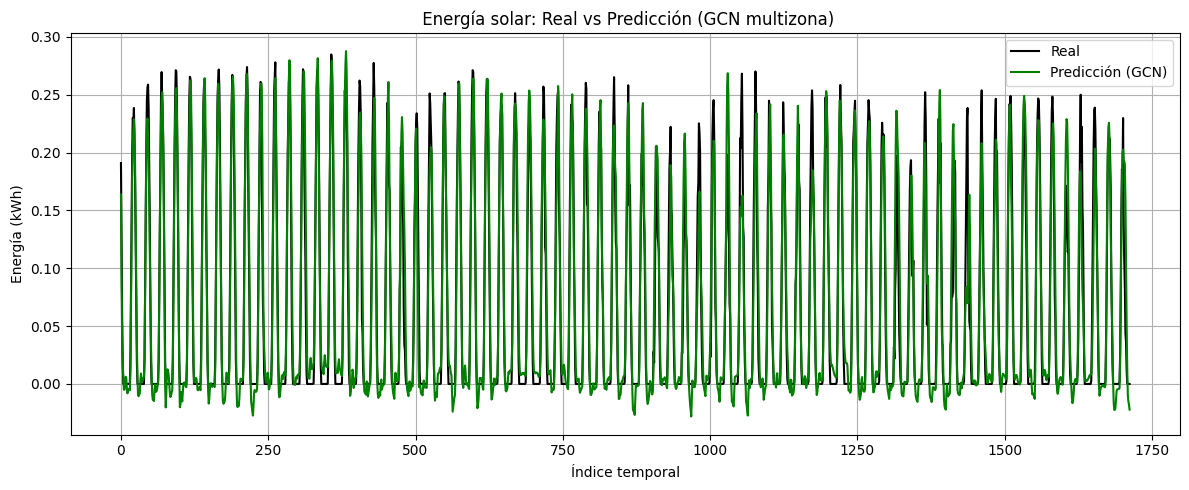

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_true_gcn, label='Real', color='black')
plt.plot(y_pred_gcn, label='Predicción (GCN)', color='green')
plt.title(" Energía solar: Real vs Predicción (GCN multizona)")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 6.2: Dispersión predicho vs real


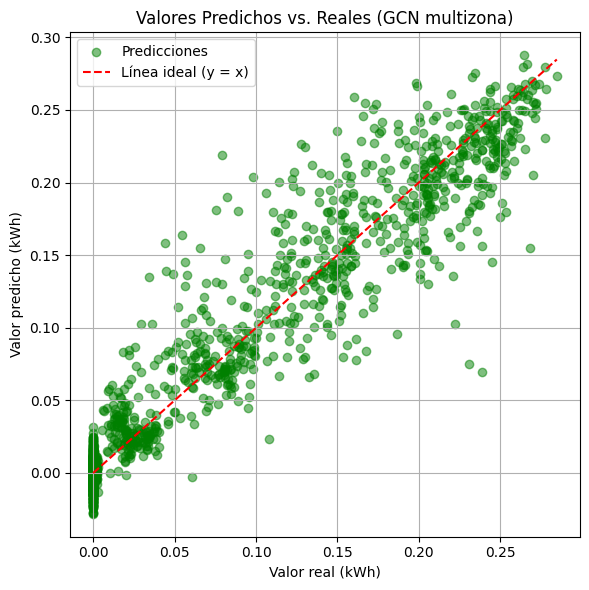

In [ ]:
y_true_flat = y_true_gcn.ravel()
y_pred_flat = y_pred_gcn.ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat, color='green', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_flat)], [0, max(y_true_flat)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GCN multizona)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
